In [14]:
from   data_viz_helpers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ScraperFC as sfc
import seaborn as sns
import traceback

In [2]:
scraper = sfc.WhoScored()
try:
    # the link below is to the Southampton-Tottenham game in September 2020
    match_data = scraper.scrape_match(
        'https://www.whoscored.com/Matches/1485202/Live/' + \
        'England-Premier-League-2020-2021-Southampton-Tottenham'
    )
#     match_data = scraper.scrape_match(
#         'https://www.whoscored.com/Matches/1558307/Live/' + \
#         'France-Ligue-1-2021-2022-Metz-Lille'
#     )
except:
    traceback.print_exc()
scraper.close()

Get the home and away player IDs.

In [3]:
home_ids = [player['playerId'] for player in match_data['matchCentreData']['home']['players']]
away_ids = [player['playerId'] for player in match_data['matchCentreData']['away']['players']]

Now let's get the average positions of every player. First, we'll find all of their events and then the average positions of those events.

In [11]:
# Build dicts for the home and away starters
home, away = dict(), dict()
for i in range(11):
    home_id = home_ids[i]
    home[home_id] = dict()
    # Get the player's name and shirt number
    for player in match_data['matchCentreData']['home']['players']:
        if player['playerId'] == home_id:
            home[home_id]['name'] = player['name']
            home[home_id]['number'] = player['shirtNo']
    # add a place to store their events and average position
    home[home_id]['events'] = list()
    
    away_id = away_ids[i]
    away[away_id] = dict()
    for player in match_data['matchCentreData']['away']['players']:
        if player['playerId'] == away_id:
            away[away_id]['name'] = player['name']
            away[away_id]['number'] = player['shirtNo']
    away[away_id]['events'] = list()

    
# Get the events for each player
for event in match_data['matchCentreData']['events']:
    if 'playerId' not in event.keys():
        continue
    elif event['playerId'] in home.keys():
        home[event['playerId']]['events'].append([event['x'], event['y']])
    elif event['playerId'] in away.keys():
        away[event['playerId']]['events'].append([event['x'], event['y']])


# get the average position of each players' events
for i in range(11):
    ID = list(home.keys())[i]
    avg_pos = np.mean(home[ID]['events'], axis=0) # find the average position of the player
    rescaled_pos = np.multiply(avg_pos, [130/100, 90/100]) # scale to our plotting range
    home[ID]['avg pos'] = rescaled_pos
    
    ID = list(away.keys())[i]
    avg_pos = np.mean(away[ID]['events'], axis=0)
    rescaled_pos = np.multiply(avg_pos, [130/100, 90/100])
    away[ID]['avg pos'] = rescaled_pos

Now let's plot those average positions. We'll add the player's number onto the plot so we can see which player was where.

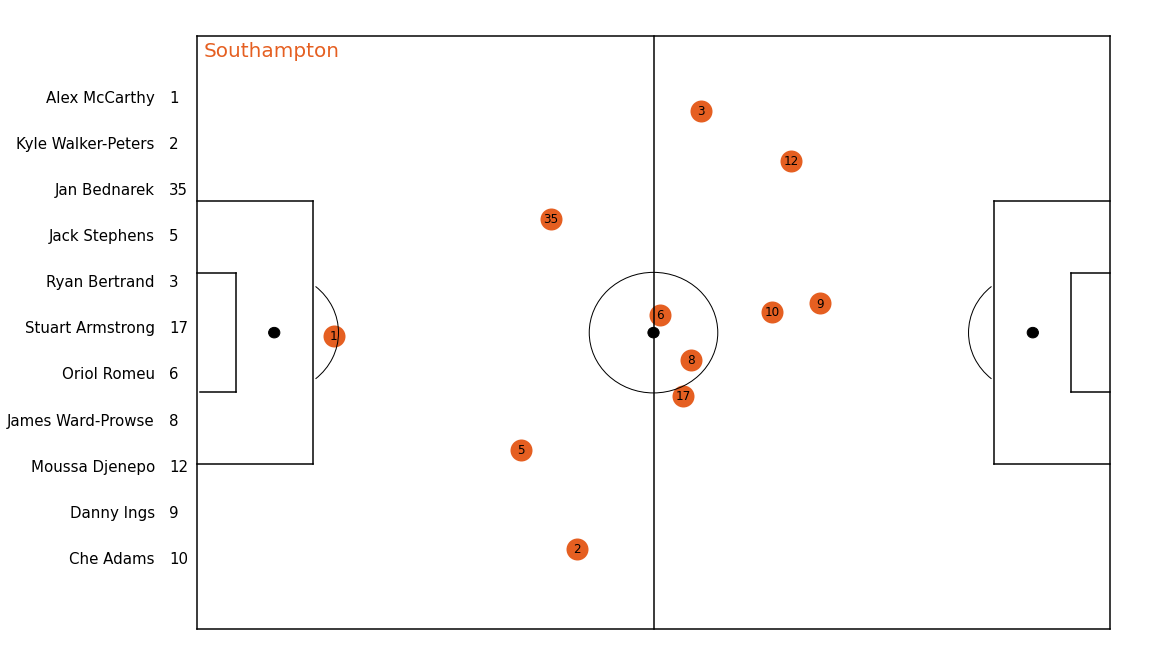

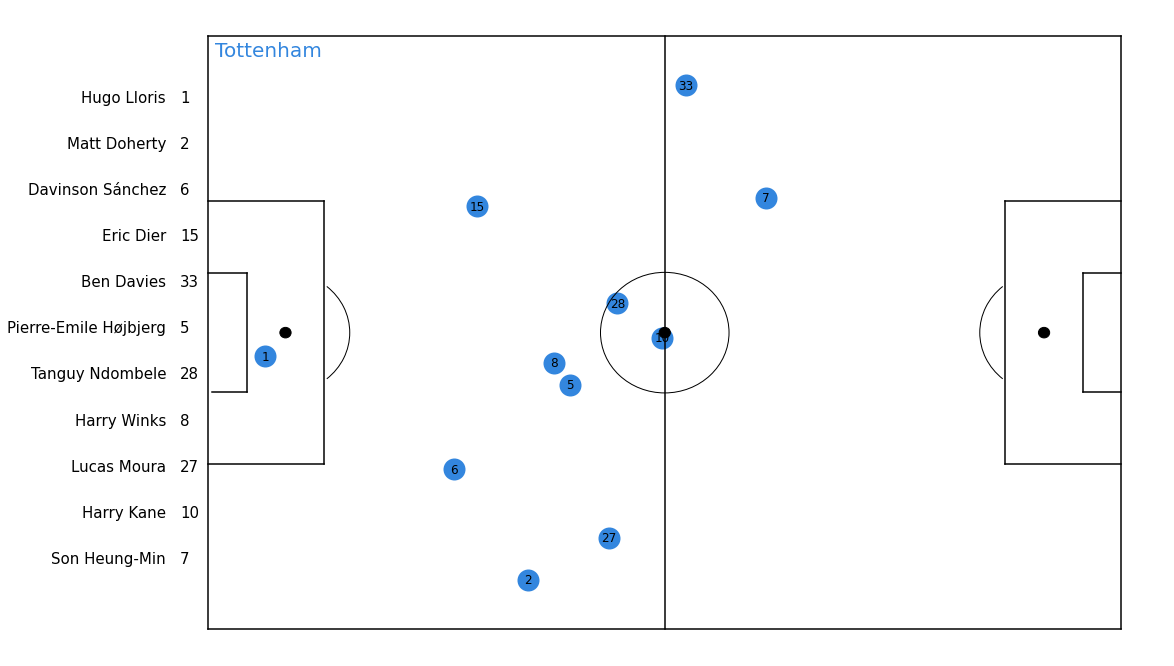

In [12]:
""" Home team """
fig, ax = plt.subplots(figsize=[18,12])
ax = plot_field(ax)
home_color = (229/255,95/255,33/255)
ax.text(1, 87, 
        match_data['matchCentreData']['home']['name'], 
        fontsize=20, 
        color=home_color)
for i in range(11):
    ID = list(home.keys())[i]
    ax.scatter(home[ID]['avg pos'][0], 
               home[ID]['avg pos'][1], 
               s=400, 
               linewidth=2,
               facecolor=home_color, 
               edgecolor=home_color)
    ax.text(home[ID]['avg pos'][0], 
            home[ID]['avg pos'][1], 
            home[ID]['number'], fontsize=12,
            horizontalalignment='center', 
            verticalalignment='center')
    ax.text(-6, 80-7*i, 
            home[ID]['name'], 
            horizontalalignment='right',
            fontsize=15)
    ax.text(-4, 80-7*i,
            home[ID]['number'],
            fontsize=15)
plt.show()


""" Away team """
fig, ax = plt.subplots(figsize=[18,12])
ax = plot_field(ax)
away_color = (51/255,134/255,222/255)
ax.text(1, 87, 
        match_data['matchCentreData']['away']['name'], 
        fontsize=20, 
        color=away_color)
for i in range(11):
    ID = list(away.keys())[i]
    ax.scatter(away[ID]['avg pos'][0], 
               away[ID]['avg pos'][1], 
               s=400, 
               linewidth=2,
               facecolor=away_color, 
               edgecolor=away_color)
    ax.text(away[ID]['avg pos'][0], 
            away[ID]['avg pos'][1], 
            away[ID]['number'], fontsize=12,
            horizontalalignment='center', 
            verticalalignment='center')
    ax.text(-6, 80-7*i, 
            away[ID]['name'], 
            horizontalalignment='right',
            fontsize=15)
    ax.text(-4, 80-7*i,
            away[ID]['number'],
            fontsize=15)
plt.show()

So now that we have the average positions of each player, we need to go through and find the passes between each pair of player.

In [50]:
home_network = pd.DataFrame(columns=home_ids, index=home_ids)
away_network = pd.DataFrame(columns=away_ids, index=away_ids)

# Get the events for each player
prev_event = None
for event in match_data['matchCentreData']['events']:
#     event_types.add(event['type']['displayName'])
#     if ('playerId' not in event.keys()):
#         continue
    if event['type']['displayName']=='Pass'and event['outcomeType']['displayName']=='Successful' \
            and prev_event and 'endX' in prev_event.keys():
        if (event['x'], event['y'])==(prev_event['endX'], prev_event['endY']):
            print('pass started where last event ended')